**Part 3: Modeling & Inference**<br>
**Task 3.1.1:  Design a Taxonomy**<br>
This code was designed to process all songs' genre, including songs with multiple genres, and map each song to one of a predefined set of six main genres. The cleanGenre column of songs D would then contain only one of these six categories, depending on where the original genre(s) fell in the mapping.

However, this approach was ultimately abandoned. After testing with all three clustering methods, it became clear that the dominant genre was overwhelmingly Rock, which made meaningful analysis difficult.

In [ ]:
from sqlalchemy import create_engine
import pandas as pd

#  ====== Create SQLAlchemy engine ======
# engine = create_engine(
#     "mssql+pyodbc://IVAN_PC\\SQLEXPRESS/TextMiningHA?driver=ODBC+Driver+17+for+SQL+Server"
# )
#
# # ====== Pull distinct genres from DB ======
# df = pd.read_sql("SELECT DISTINCT genre, song_id FROM songs", engine)
#
# # ====== Extract unique subgenres ======
# subgenres = set()
# for row in df['genre'].dropna():
#     for tag in row.split(','):
#         subgenres.add(tag.strip().lower())
#
# # ====== Define main genre groups ======
# genre_groups = {
#     "Rock": [],
#     "Metal": [],
#     "Pop": [],
#     "Hip-Hop": [],
#     "Jazz": [],
#     "Country": [],
#     "World": [],
# }
#
# # ====== Assign subgenres to main groups ======
# for genre in subgenres:
#     g = genre.lower()
#     if g in ['alt-rock', 'alternative', 'garage', 'grunge', 'hard-rock', 'indie', 'indie-pop',
#              'punk', 'punk-rock', 'psych-rock', 'rock', 'rock-n-roll', 'rockabilly']:
#         genre_groups["Rock"].append(g)
#     elif g in ['black-metal', 'death-metal', 'metal', 'guitar','metalcore', 'hardcore', 'industrial','goth']:
#         genre_groups["Metal"].append(g)
#     elif g in ['pop', 'power-pop', 'dance', 'disco', 'house', 'progressive-house','mandopop',
#                'j-pop', 'j-rock', 'j-dance', 'synth-pop', 'electro', 'electronic', 'edm','hip-hop', 'r-n-b', 'trip-hop', 'groove', 'funk']:
#         genre_groups["Pop"].append(g)
#     elif g in ['jazz', 'classical', 'opera', 'piano', 'new-age', 'show-tunes','soul']:
#         genre_groups["Jazz"].append(g)
#     elif g in ['acoustic', 'folk', 'singer-songwriter', 'songwriter', 'country', 'bluegrass', 'honky-tonk']:
#         genre_groups["Country"].append(g)
#     else:
#         genre_groups["World"].append(g)
#
# # ====== Flatten mapping for lookup ======
# mapping_dict = {kw: main for main, keywords in genre_groups.items() for kw in keywords}
#
# # ====== Map and update genres in DB ======
# from sqlalchemy import text
#
#
# # ====== Map and update genres with majority match ======
# with engine.begin() as conn:
#     df_all = pd.read_sql("SELECT song_id, genre FROM songs WHERE genre IS NOT NULL", conn)
#
#     for _, row in df_all.iterrows():
#         song_id = row['song_id']
#         genres = [g.strip().lower() for g in row['genre'].split(',')]
#         unique_genres = list(dict.fromkeys(genres))
#
#         # Count matches per main genre
#         match_counts = {}
#         for main_genre, keywords in genre_groups.items():
#             count = sum(1 for g in unique_genres if g in keywords)
#             if count > 0:
#                 match_counts[main_genre] = count
#
#         # Pick the main genre with the highest matches
#         if match_counts:
#             chosen_value = max(match_counts, key=match_counts.get)
#         else:
#             chosen_value = None
#
#         # Update DB
#         stmt = text("UPDATE songs SET cleanGenre = :cleanGenre WHERE song_id = :song_id")
#         conn.execute(stmt, {"cleanGenre": chosen_value, "song_id": song_id})
#
# print("Genre cleaning completed: cleanGenre populated using majority-match rule.")

Initially, this code was designed to clean each genre by simply removing duplicates, leaving a single genre per song. However, when encountering songs with multiple genres, I decided to pick the rarest genre in the dataset.

This approach was intended to make the data more interesting and to improve the potential for clustering and meaningful analysis, by highlighting less common genres rather than defaulting to the dominant ones.

In [1]:
from sqlalchemy import create_engine, text
import pandas as pd
from collections import Counter

# ====== Create SQLAlchemy engine ======
engine = create_engine(
    "mssql+pyodbc://IVAN_PC\\SQLEXPRESS/TextMiningHA?driver=ODBC+Driver+17+for+SQL+Server"
)

# ====== Pull song_id and genre ======
df = pd.read_sql("SELECT song_id, genre FROM songs", engine)

# ====== Count frequency of all genres ======
all_genres = []
for g in df['genre']:
    all_genres.extend([x.strip().lower() for x in g.split(',')])
freq = Counter(all_genres)

# ====== Determine cleanGenre safely ======
def choose_genre(g):
    genres = [x.strip().lower() for x in g.split(',')]
    if len(genres) == 1:
        return genres[0]  # single genre
    # multiple genres: pick the rarest by frequency
    rarest = min(genres, key=lambda x: freq.get(x, float('inf')))
    return rarest

df['cleanGenre'] = df['genre'].apply(choose_genre)

# ====== Update the database ======
with engine.begin() as conn:
    stmt = text("UPDATE songs SET cleanGenre = :cleanGenre WHERE song_id = :song_id")
    for _, row in df.iterrows():
        conn.execute(stmt, {"cleanGenre": row['cleanGenre'], "song_id": row['song_id']})

print("Genre cleaning completed: cleanGenre populated using rarest-genre rule.")


Genre cleaning completed: cleanGenre populated using rarest-genre rule.


**Part 3: Modeling & Inference**<br>
In the following cell transforms the cleaned lyrics tokens onto sparse TF-IDF matrix (weighted word importance, including unigrams + bigrams), reduces them dimensionally  with LSA, and prints both the word space and reduced semantic representation for further clustering/analysis.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import ast
from sqlalchemy import create_engine



# Create the SQLAlchemy engine
conn_str = "mssql+pyodbc://IVAN_PC\\SQLEXPRESS/TextMiningHA?driver=ODBC+Driver+17+for+SQL+Server"


# Pull SimilarityData
df = pd.read_sql(f"""
    SELECT song_id, name, cleanTokens, genre,cleanGenre
    FROM  songs
    WHERE cleanTokens IS NOT NULL
""", engine)

# --- Convert token strings to lists and join into a single string ---
df['clean_text'] = df['cleanTokens'].apply(ast.literal_eval)  # convert string to list
df['clean_text'] = df['clean_text'].apply(lambda tokens: ' '.join(tokens))

# TF-IDF vectorizer
vectorizer = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    min_df=30,
    max_df=0.9,
    lowercase=True,
    strip_accents="unicode",
    token_pattern=r"\b\w+\b"
)
X_sparse = vectorizer.fit_transform(df['clean_text'])

# --- TruncatedSVD for LSA ---
n_components = 5
random_state = 100
svd = TruncatedSVD(n_components=n_components, random_state=random_state)
X_tfidf = svd.fit_transform(X_sparse)


# Optional: DataFrame for inspection
tfidf_df = pd.DataFrame(
    X_tfidf,
    columns=[f'LSA_{i+1}' for i in range(X_tfidf.shape[1])],
    index=df['name']
)




# ---- Bag Of Words in format {'...','...',...} ----
vocab = vectorizer.get_feature_names_out()
bow_string = "{ " + ", ".join([f"'{w}'" for w in vocab]) + " }"
print(bow_string, len(bow_string))

print(tfidf_df.head())

# ---- count and list the entire wordspace ----
total_words = len(vectorizer.get_feature_names_out())
print("Total unique words (features):", total_words)
print(sorted(vectorizer.get_feature_names_out()))   # <— uncomment to show all words

# ---- choose songs to print horizontally ----
rows_selected = tfidf_df.iloc[6:8]
# for song_name, row in rows_selected.iterrows():
#     words_scores = [f"{word}:{score:.4f}" for word, score in row.items()]
#     print(f"{song_name} -> {' | '.join(words_scores)}\n")


{ 'across', 'afraid', 'air', 'alive', 'alone', 'alone i', 'along', 'alright', 'always', 'angel', 'another', 'anymore', 'anyone', 'anything', 'apart', 'arms', 'around', 'around i', 'around you', 'ask', 'away', 'away i', 'away you', 'babe', 'baby', 'baby i', 'baby not', 'baby you', 'back', 'back i', 'back you', 'bad', 'beat', 'beautiful', 'bed', 'begin', 'behind', 'believe', 'believe i', 'beneath', 'best', 'better', 'big', 'bit', 'black', 'blame', 'blind', 'blood', 'blue', 'body', 'born', 'bout', 'boy', 'boys', 'brain', 'break', 'breath', 'breathe', 'bridge', 'bright', 'bring', 'broke', 'broken', 'brother', 'burn', 'burning', 'but', 'but i', 'but if', 'but not', 'but you', 'call', 'called', 'calling', 'came', 'cannot', 'cannot get', 'cannot you', 'car', 'care', 'catch', 'caught', 'chance', 'change', 'child', 'children', 'christmas', 'city', 'clean', 'clear', 'close', 'closer', 'clouds', 'cold', 'come', 'come back', 'comes', 'coming', 'control', 'cool', 'could', 'could not', 'crazy', 'cro

**Scree Plot - Elbow Method**<br>This code helps to select the best number of clusters for KMeans by plotting the inertia curve and finding the elbow point automatically.

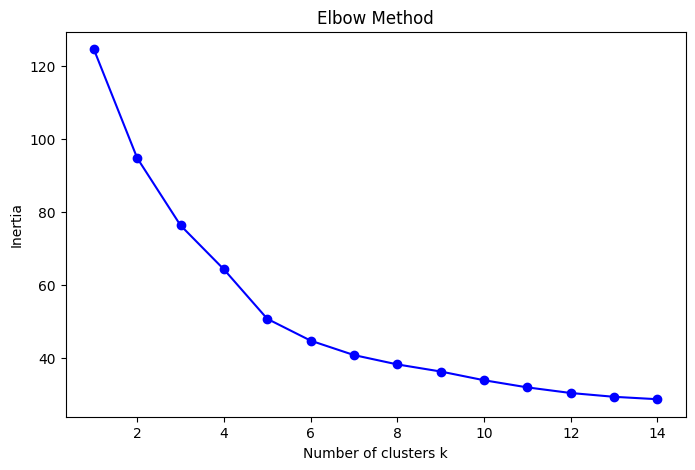

Elbow at k = 5


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Suppose X is your feature matrix
inertia = []
K = range(1,15)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()


from kneed import KneeLocator

knee = KneeLocator(K, inertia, curve='convex', direction='decreasing')
print("Elbow at k =", knee.knee)

**Task 3.1.2. Apply Multiple Clustering Techniques** K-means method

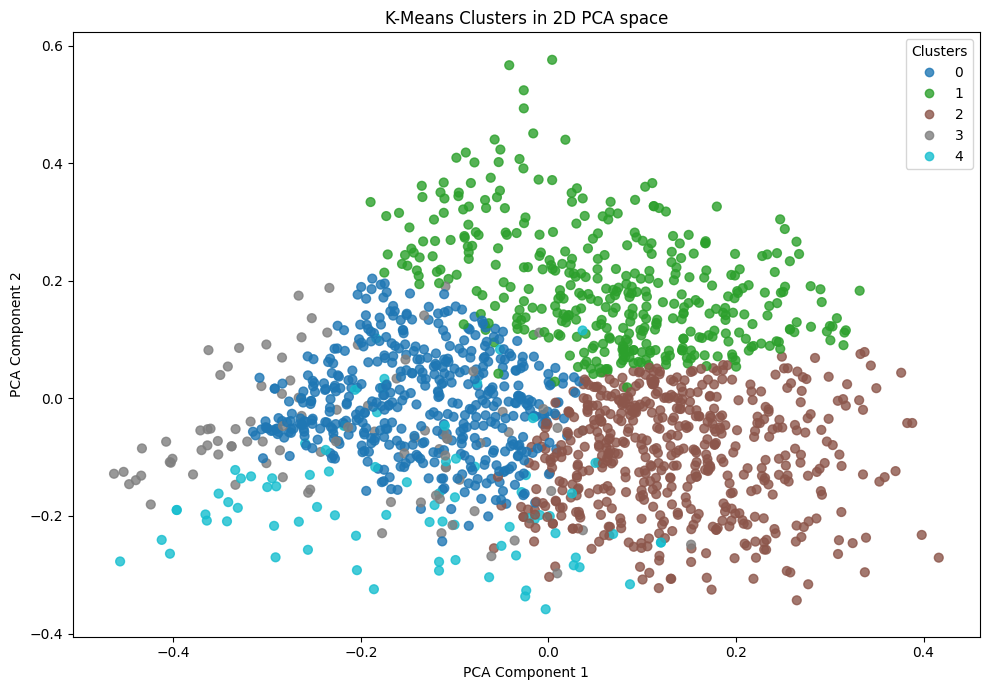


=== Cluster 0 (473 songs) | Top genres: death-metal (33/473), psych-rock (32/473), grunge (28/473), honky-tonk (27/473), synth-pop (25/473) ===

=== Cluster 1 (390 songs) | Top genres: honky-tonk (34/390), grunge (31/390), hard-rock (25/390), synth-pop (24/390), psych-rock (21/390) ===

=== Cluster 2 (523 songs) | Top genres: grunge (55/523), hard-rock (42/523), honky-tonk (41/523), piano (24/523), dance (22/523) ===

=== Cluster 3 (93 songs) | Top genres: honky-tonk (14/93), psych-rock (10/93), hard-rock (7/93), power-pop (5/93), alt-rock (5/93) ===

=== Cluster 4 (79 songs) | Top genres: grunge (10/79), power-pop (9/79), honky-tonk (8/79), blues (5/79), british (5/79) ===


In [4]:
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# ====== Parameters ======
k = 5 # number of clusters
random_state = 42

# ====== K-Means Clustering ======
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=42)
kmeans.fit(X_tfidf)

# ====== Store cluster labels in DataFrame ======
df['kmeans_label'] = kmeans.labels_

# ====== PCA for Visualization ======
pca = PCA(n_components=2, random_state=random_state)
X_pca = pca.fit_transform(X_tfidf)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                      c=df['kmeans_label'], cmap='tab10', alpha=0.8, s=40)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clusters in 2D PCA space')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.tight_layout()
plt.show()

# ====== Display all rows and columns (no truncation) ======
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

# ====== Subgenre Summary and Export (without splitting cleanGenre) ======
for cluster_id in sorted(df['kmeans_label'].unique()):
    cluster_songs = df[df['kmeans_label'] == cluster_id]
    total_songs = len(cluster_songs)

    # Count exact cleanGenre strings (no splitting)
    genre_counts = cluster_songs['cleanGenre'].value_counts()
    top5_genres = genre_counts.head(5)
    top5_summary = ", ".join([f"{g} ({c}/{total_songs})" for g, c in top5_genres.items()])

    print(f"\n=== Cluster {cluster_id} ({total_songs} songs) | Top genres: {top5_summary} ===")

    # Save cluster songs to CSV
    output_folder = r"MyFiles"
    filename = os.path.join(output_folder, f"soft_cluster_{cluster_id}.csv")
    cluster_songs[['name', 'genre', 'cleanGenre', 'kmeans_label']].to_csv(filename, index=False)


**Task 3.1.3. Visualise and Evaluate** K-means method

Proportional Confusion Matrix (Top genres, in %):


,Death-Metal,honky-Tonk,grunge,psych-rock,power-pop
grunge,5.92,7.95,10.52,4.30,12.66
honky-tonk,5.71,8.72,7.84,15.05,10.13
psych-rock,6.77,5.38,3.25,10.75,2.53
synth-pop,5.29,6.15,3.82,3.23,5.06
hard-rock,4.65,6.41,8.03,7.53,2.53
piano,2.54,4.10,4.59,3.23,6.33
industrial,3.38,2.31,3.06,1.08,3.80
disco,3.81,4.87,2.29,1.08,2.53
death-metal,6.98,0.51,0.96,1.08,0.00
"hard-rock, metal",0.00,0.00,0.00,0.00,0.00


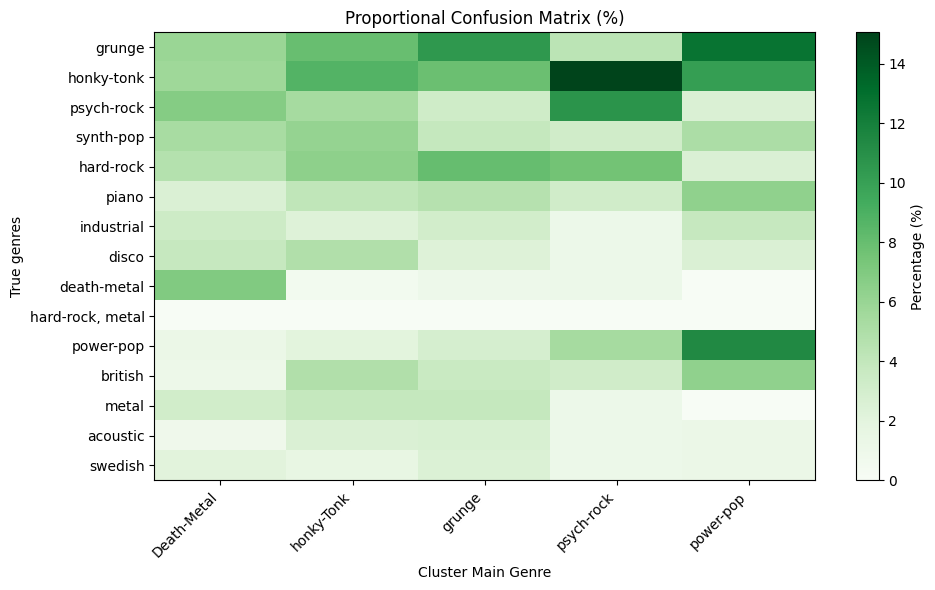

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Top 15 genres and cluster IDs
top_genres = df['genre'].value_counts().head(15).index.tolist()
cluster_ids = sorted(df['kmeans_label'].unique())

# ===== Manually assign cluster labels =====
manual_labels = {
    0: "Death-Metal",
    1: "honky-Tonk",
    2: "grunge",
    3: "psych-rock",
    4: "power-pop",

}

# Build proportional confusion matrix
proportional_cm = pd.DataFrame(0, index=top_genres, columns=cluster_ids, dtype=float)
for cluster_id in cluster_ids:
    cluster_songs = df[df['kmeans_label'] == cluster_id]
    genre_counts = cluster_songs['cleanGenre'].value_counts()
    proportional_cm.loc[genre_counts.index.intersection(top_genres), cluster_id] = (
        genre_counts.loc[genre_counts.index.intersection(top_genres)] / len(cluster_songs)
    )

# Convert to percentages + rename cluster columns with top genres
percentage_cm = proportional_cm * 100
percentage_cm.columns = [manual_labels [i] for i in cluster_ids]

# Show as DataFrame
print("Proportional Confusion Matrix (Top genres, in %):")
display(percentage_cm.round(2))

# Heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(percentage_cm, cmap="Greens", aspect='auto')
cbar = plt.colorbar(im); cbar.set_label("Percentage (%)")
plt.xticks(ticks=np.arange(len(percentage_cm.columns)), labels=percentage_cm.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(percentage_cm.index)), labels=percentage_cm.index)
plt.xlabel("Cluster Main Genre"); plt.ylabel("True genres"); plt.title("Proportional Confusion Matrix (%)")
plt.tight_layout()
plt.show()


**Task 3.1.4. Evaluate Inferred Labels** K-means

In [6]:
major_genres = [
    "synth-pop", "honky-tonk", "hard-rock", "psych-rock", "grunge",
    "piano", "hard-rock, metal", "death-metal", "power-pop", "dance"
]
# Keep only rows with major genres
df_major = df[df['cleanGenre'].isin(major_genres)].copy()

cluster_to_genre = {}
for cluster_id in df_major['kmeans_label'].unique():
    cluster_songs = df_major[df_major['kmeans_label'] == cluster_id]
    majority_genre = cluster_songs['cleanGenre'].value_counts().idxmax()
    cluster_to_genre[cluster_id] = majority_genre

# Predicted labels
y_pred = df_major['kmeans_label'].map(cluster_to_genre)
y_true = df_major['cleanGenre']

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print(classification_report(y_true, y_pred, zero_division=0))
print("Macro Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted', zero_division=0))

              precision    recall  f1-score   support

       dance       0.00      0.00      0.00        41
 death-metal       0.18      0.80      0.29        41
      grunge       0.23      0.51      0.32       128
   hard-rock       0.00      0.00      0.00        98
  honky-tonk       0.22      0.39      0.28       124
       piano       0.00      0.00      0.00        60
   power-pop       0.00      0.00      0.00        43
  psych-rock       0.00      0.00      0.00        82
   synth-pop       0.00      0.00      0.00        76

    accuracy                           0.21       693
   macro avg       0.07      0.19      0.10       693
weighted avg       0.09      0.21      0.13       693

Macro Precision: 0.06903055617395852
Macro Recall: 0.18886525810822624
Macro F1: 0.09799331535970432
Weighted F1: 0.12511895417668714


**Task 3.1.2. Apply Multiple Clustering Techniques** Hierarchical Method

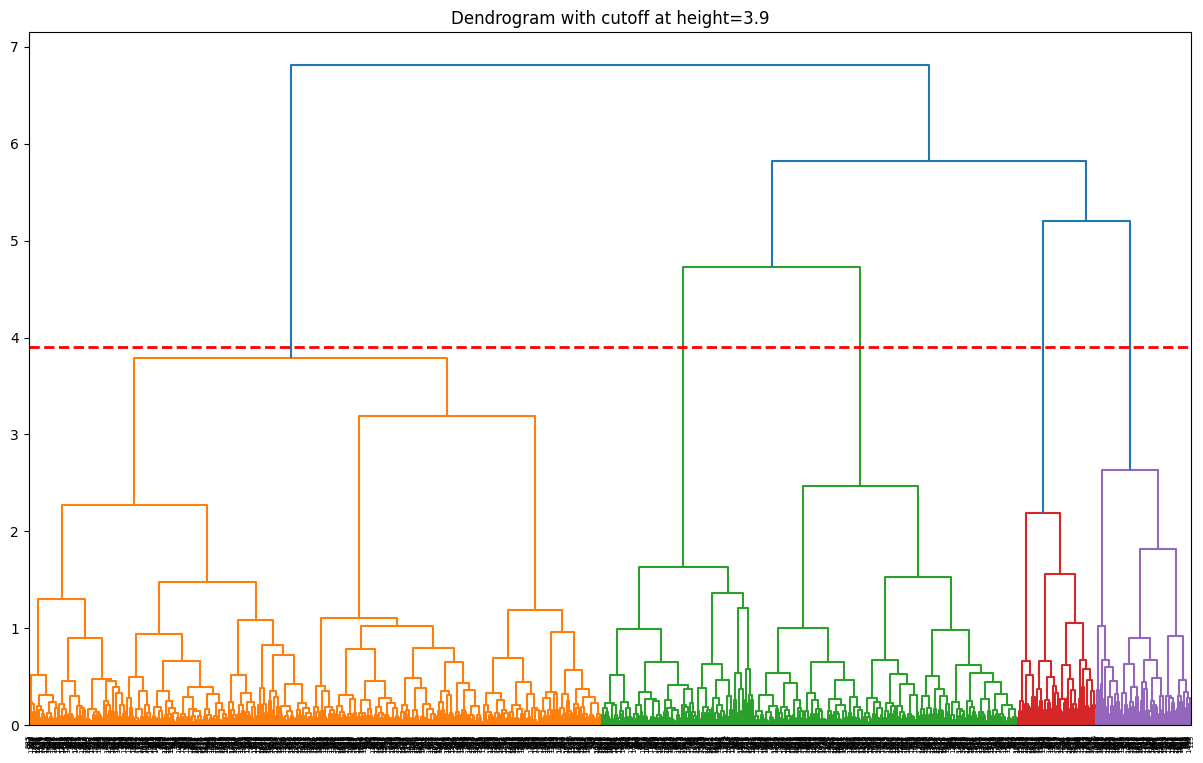

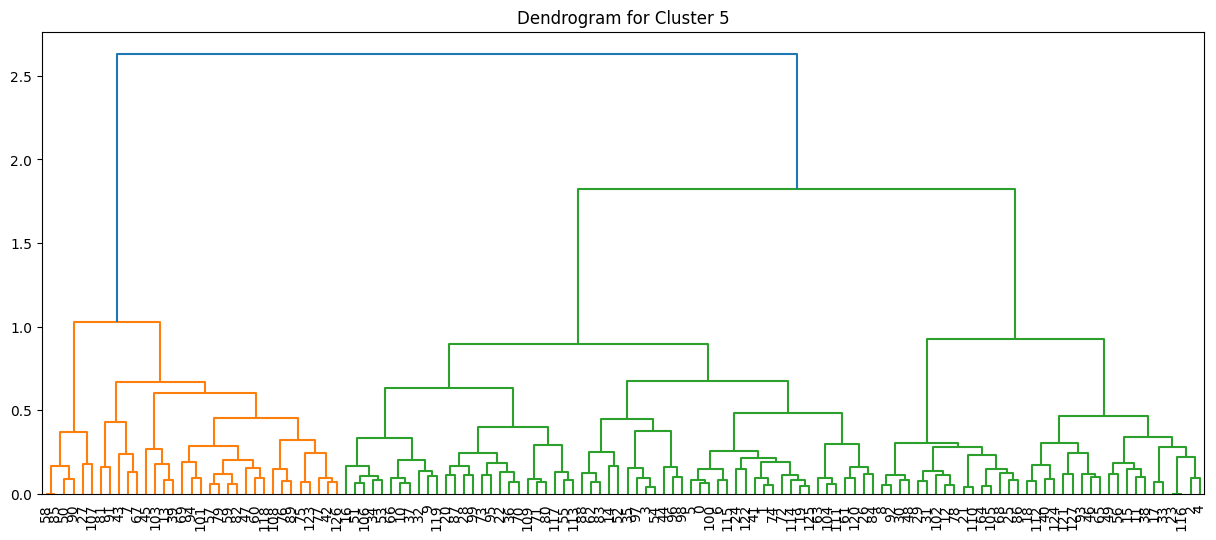

In [7]:
#===================================================
#hard boundaries in hierarchical methods { Agglomerative Clustering}
#=====================================================
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


Z = linkage(X_tfidf, method='ward')

plt.figure(figsize=(15, 9))
dendrogram(Z)
cut_height = 3.9
plt.axhline(y=cut_height, c='red', lw=2, linestyle='--')
plt.title(f'Dendrogram with cutoff at height={cut_height}')
plt.show()

clusters = fcluster(Z, t=cut_height, criterion='distance')
df['hierarchical_cluster'] = clusters  # Add cluster labels

#Step 4: Focus on a specific cluster
cluster_number = 5
cluster_mask = df['hierarchical_cluster'] == cluster_number
Z_sub = linkage(X_tfidf[cluster_mask], method='ward')

plt.figure(figsize=(15, 6))
dendrogram(Z_sub, leaf_rotation=90, leaf_font_size=10)
plt.title(f"Dendrogram for Cluster {cluster_number}")
plt.show()

# --- Sorted subset table ---
subset = df.loc[cluster_mask, ['song_id', 'name', 'cleanGenre']].copy()
subset['DB_RowNo'] = np.arange(1, len(subset)+1)

# Sort by genre frequency
genre_order = subset['cleanGenre'].value_counts().index
subset['cleanGenre'] = pd.Categorical(subset['cleanGenre'], categories=genre_order, ordered=True)
subset_sorted = subset.sort_values('cleanGenre')[['DB_RowNo', 'name', 'cleanGenre']].reset_index(drop=True)

#display(subset_sorted) optional for analysing the zoomed cluster


**Task3.1.3. Visualise and Evaluate** Hierarchical Method

In [8]:
import numpy as np
from collections import Counter

# Assign hierarchical clusters
df['cluster'] = clusters

# Loop through each cluster
for cluster_id in np.unique(clusters):
    cluster_songs = df[df['cluster'] == cluster_id]
    total_songs = len(cluster_songs)

    # Count full genres as-is (even if multiple genres in one string)
    genre_counts = cluster_songs['cleanGenre'].dropna().value_counts()

    # Top 5 genres
    top_genres = genre_counts.head(5)

    # Build summary string
    top_genre_summary = ", ".join([f"{g} ({c}/{total_songs})" for g, c in top_genres.items()])

    # Print cluster header
    print(f"\n=== Cluster {cluster_id} ({total_songs} songs) | Top genres: {top_genre_summary} ===")

    # Save cluster songs to CSV
    output_folder = r"MyFiles"
    filename = os.path.join(output_folder, f"hard_cluster_{cluster_id}.csv")
    cluster_songs[['name', 'genre', 'cleanGenre', 'kmeans_label']].to_csv(filename, index=False)



=== Cluster 1 (768 songs) | Top genres: grunge (72/768), honky-tonk (57/768), hard-rock (53/768), piano (35/768), british (32/768) ===

=== Cluster 2 (204 songs) | Top genres: psych-rock (18/204), grunge (17/204), honky-tonk (16/204), synth-pop (13/204), hard-rock (13/204) ===

=== Cluster 3 (354 songs) | Top genres: death-metal (27/354), psych-rock (22/354), grunge (22/354), synth-pop (21/354), hard-rock (18/354) ===

=== Cluster 4 (104 songs) | Top genres: honky-tonk (16/104), psych-rock (12/104), hard-rock (6/104), grunge (5/104), power-pop (5/104) ===

=== Cluster 5 (128 songs) | Top genres: honky-tonk (17/128), grunge (12/128), power-pop (11/128), hard-rock (8/128), psych-rock (8/128) ===


Proportional Confusion Matrix (Top genres, in %):


,Death-Metal,honky-Tonk,grunge,psych-rock,power-pop
grunge,5.92,7.95,10.52,4.30,12.66
honky-tonk,5.71,8.72,7.84,15.05,10.13
psych-rock,6.77,5.38,3.25,10.75,2.53
synth-pop,5.29,6.15,3.82,3.23,5.06
hard-rock,4.65,6.41,8.03,7.53,2.53
piano,2.54,4.10,4.59,3.23,6.33
industrial,3.38,2.31,3.06,1.08,3.80
disco,3.81,4.87,2.29,1.08,2.53
death-metal,6.98,0.51,0.96,1.08,0.00
"hard-rock, metal",0.00,0.00,0.00,0.00,0.00


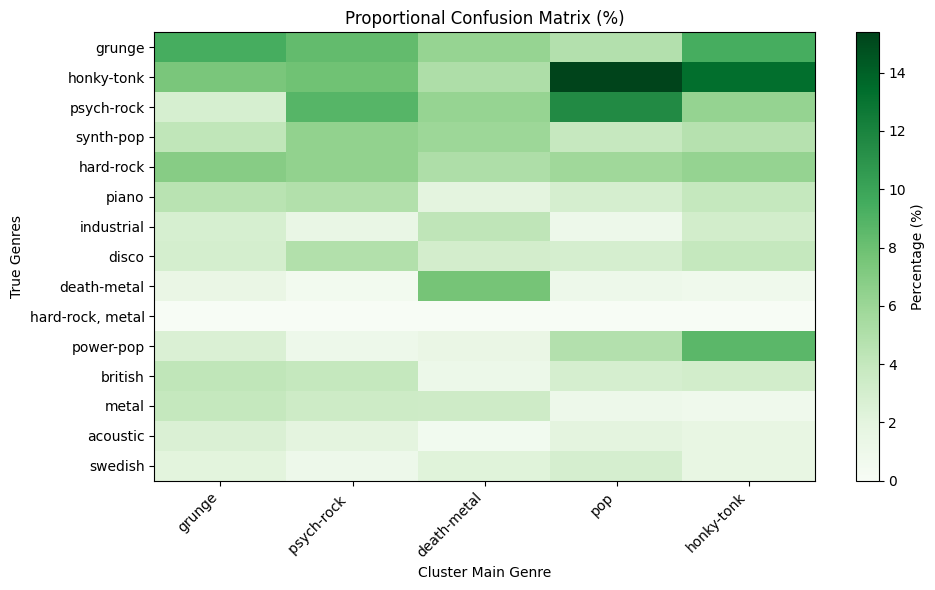

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# ===== Top 15 full genres =====
top_15_genres = df['genre'].value_counts().head(15).index.tolist()
cluster_ids = sorted(df['cluster'].unique())

# ===== Manually assign a genre to each cluster =====
# Example: cluster 0 -> 'rock', cluster 1 -> 'jazz', etc.
manual_labels = {
    1: 'grunge',
    2: 'psych-rock ',
    3: 'death-metal',
    4: 'pop',
    5: 'honky-tonk'
}

# ===== Initialize matrix =============
proportional_cm = pd.DataFrame(0, index=top_15_genres, columns=cluster_ids, dtype=float)
topic_labels = []

# ===== Fill matrix & use manual labels =====
for cluster_id in cluster_ids:
    cluster_songs = df[df['cluster'] == cluster_id]
    genre_counts = cluster_songs['cleanGenre'].dropna().value_counts()

    # Use your manual label instead of top genre
    top_genre_label = manual_labels.get(cluster_id, f"Cluster {cluster_id}")
    topic_labels.append(top_genre_label)

    for genre, count in genre_counts.items():
        if genre in top_15_genres:
            proportional_cm.loc[genre, cluster_id] = count / len(cluster_songs)


 # ===== Convert proportional matrix to percentages =====
percentage_table = (percentage_cm).round(2)  # round to 2 decimal places

# ===== Display table =====
print("Proportional Confusion Matrix (Top genres, in %):")
display(percentage_table)

# ===== Convert proportional matrix to percentages =====
percentage_cm = proportional_cm * 100  # use proportional_cm with manual labels

# ===== Replace numeric column IDs with manual labels =====
percentage_cm.columns = [manual_labels.get(c, f"Cluster {c}") for c in percentage_cm.columns]

# ===== Heatmap =====
plt.figure(figsize=(10, 6))
im = plt.imshow(percentage_cm.values, cmap="Greens", aspect='auto')
cbar = plt.colorbar(im)
cbar.set_label("Percentage (%)")

plt.xticks(ticks=np.arange(len(percentage_cm.columns)), labels=percentage_cm.columns, rotation=45, ha="right")
plt.yticks(ticks=np.arange(len(percentage_cm.index)), labels=percentage_cm.index)

plt.xlabel("Cluster Main Genre")
plt.ylabel("True Genres")
plt.title("Proportional Confusion Matrix (%)")
plt.tight_layout()
plt.show()

**TASK 3.1.4. Evaluate Inferred Labels** Hierarchical Method

In [10]:
top_15_genres = df['cleanGenre'].value_counts().head(15).index.tolist()

# Keep only rows with these top genres
df_major = df[df['cleanGenre'].isin(top_15_genres)].copy()

cluster_to_genre = {}
for cluster_id in df_major['kmeans_label'].unique():
        cluster_songs = df_major[df_major['kmeans_label'] == cluster_id]
        majority_genre = cluster_songs['cleanGenre'].value_counts().idxmax()
        cluster_to_genre[cluster_id] = majority_genre

y_pred = df_major['kmeans_label'].map(cluster_to_genre)
y_true = df_major['cleanGenre']

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

print("Classification Report (Top 15 genres):\n")
print(classification_report(y_true, y_pred, zero_division=0))

print("Macro Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted', zero_division=0))


Classification Report (Top 15 genres):

              precision    recall  f1-score   support

    alt-rock       0.00      0.00      0.00        46
     british       0.00      0.00      0.00        51
       dance       0.00      0.00      0.00        41
 death-metal       0.12      0.80      0.22        41
       disco       0.00      0.00      0.00        52
      grunge       0.16      0.51      0.25       128
   hard-rock       0.00      0.00      0.00        98
  honky-tonk       0.15      0.39      0.22       124
  industrial       0.00      0.00      0.00        45
       metal       0.00      0.00      0.00        51
       piano       0.00      0.00      0.00        60
   power-pop       0.00      0.00      0.00        43
  psych-rock       0.00      0.00      0.00        82
        rock       0.00      0.00      0.00        43
   synth-pop       0.00      0.00      0.00        76

    accuracy                           0.15       981
   macro avg       0.03      0.11      0

**TASK 3.1.2. Apply Multiple Clustering Techniques** LDA Method

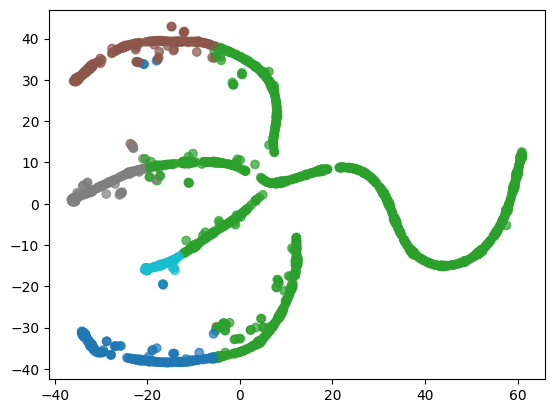


=== Topic 0 (86 songs) | Top subgenres: hard-rock (8), death-metal (8), psych-rock (7), grunge (6), metal (5) ===

=== Topic 1 (1111 songs) | Top subgenres: grunge (100), honky-tonk (83), hard-rock (73), synth-pop (62), psych-rock (50) ===

=== Topic 2 (50 songs) | Top subgenres: jazz (5), new-age (5), death-metal (4), goth (3), world-music (3) ===

=== Topic 3 (150 songs) | Top subgenres: honky-tonk (16), psych-rock (13), grunge (12), jazz (8), alt-rock (8) ===

=== Topic 4 (161 songs) | Top subgenres: honky-tonk (20), hard-rock (12), psych-rock (10), grunge (9), alt-rock (8) ===


In [11]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Step 1: Convert text to Bag-of-Words
count_vectorizer = CountVectorizer(max_features=55000)
X_counts = count_vectorizer.fit_transform(df['clean_text'])

# Step 2: Fit LDA
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_counts)


# LDA topic vectors
topic_vectors = lda.transform(X_counts)
df['assigned_topic'] = topic_vectors.argmax(axis=1)

# Cluster in topic space
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(topic_vectors)
df['kmeans_label'] = kmeans.labels_


X_tsne = TSNE(n_components=2, random_state=42, perplexity=30).fit_transform(topic_vectors)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['kmeans_label'], cmap='tab10', alpha=0.7)
plt.show()

# Print songs per topic
for topic_id in sorted(df['assigned_topic'].unique()):
    topic_songs = df[df['assigned_topic'] == topic_id]
    total_songs = len(topic_songs)

    # Split all genre strings by comma and flatten
    all_subgenres = topic_songs['cleanGenre'].dropna().apply(lambda x: [g.strip() for g in x.split(',')])
    all_subgenres_flat = [g for sublist in all_subgenres for g in sublist]

    # Count each subgenre
    from collections import Counter
    subgenre_counts = Counter(all_subgenres_flat)

    # Take top 5
    top5_subgenres = subgenre_counts.most_common(5)
    top5_str = ", ".join([f"{g} ({c})" for g, c in top5_subgenres])

    print(f"\n=== Topic {topic_id} ({total_songs} songs) | Top subgenres: {top5_str} ===")
    #print(topic_songs[['name', 'cleanGenre', 'assigned_topic']].to_string(index=False))



**Task 3.1.3. Visualise and Evaluate** LDA Method

Proportional Confusion Matrix (Top genres, in %):
                 hard-rock grunge death-metal psych-rock honky-tonk
grunge               6.98%   9.0%        2.0%       8.0%      5.59%
honky-tonk           3.49%  7.47%        4.0%     10.67%     12.42%
psych-rock           8.14%   4.5%        4.0%      8.67%      6.21%
synth-pop            4.65%  5.58%        2.0%      2.67%      3.11%
hard-rock             9.3%  6.57%        2.0%      2.67%      7.45%
piano                4.65%  4.14%        2.0%      3.33%      2.48%
industrial           2.33%  2.79%        2.0%      3.33%      3.73%
disco                2.33%  3.87%        2.0%       4.0%       0.0%
death-metal           9.3%  1.71%        8.0%      4.67%      1.86%
hard-rock, metal      0.0%   0.0%        0.0%       0.0%       0.0%
power-pop            4.65%  2.97%        2.0%      2.67%      0.62%
british               0.0%  3.69%        0.0%      3.33%      3.11%
metal                5.81%  3.33%        2.0%      1.33%      3.73

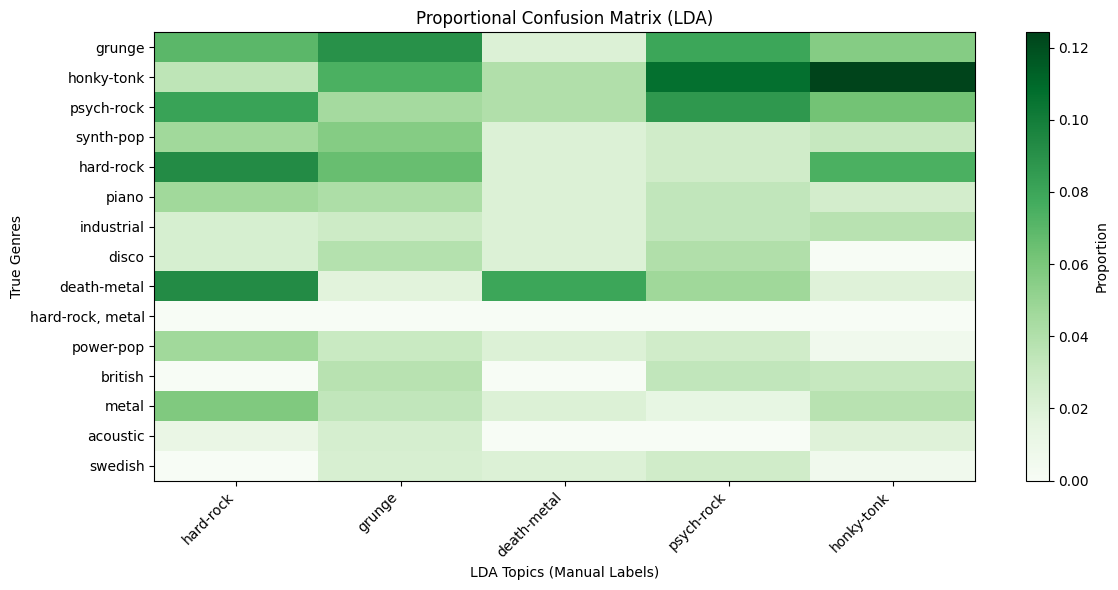

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ===== Top genres =====
top_10_genres = df['genre'].value_counts().head(15).index.tolist()

# ===== LDA topics =====
topic_ids = sorted(df['assigned_topic'].unique())

# ===== Manually assign labels to topics =====
manual_labels = {
    0: "hard-rock",
    1: "grunge",
    2: "death-metal",
    3: "psych-rock",
    4: "honky-tonk",

}

# Initialize proportional matrix
proportional_cm = pd.DataFrame(0, index=top_10_genres, columns=topic_ids, dtype=float)

# Fill matrix
for topic_id in topic_ids:
    topic_songs = df[df['assigned_topic'] == topic_id]
    genre_counts = topic_songs['cleanGenre'].value_counts()
    for genre, count in genre_counts.items():
        if genre in top_10_genres:
            proportional_cm.loc[genre, topic_id] = count / len(topic_songs) if len(topic_songs) > 0 else 0

# ===== Replace numeric topic IDs with manual labels =====
proportional_cm.columns = [manual_labels.get(tid, f"Topic {tid}") for tid in proportional_cm.columns]

# Convert to percentages
percentage_cm = proportional_cm * 100
percentage_table = percentage_cm.round(2).astype(str) + "%"

print("Proportional Confusion Matrix (Top genres, in %):")
print(percentage_table)

# ===== Plot heatmap =====
plt.figure(figsize=(12, 6))
plt.imshow(proportional_cm, cmap="Greens", aspect='auto')
plt.colorbar(label="Proportion")
plt.xticks(ticks=np.arange(len(proportional_cm.columns)), labels=proportional_cm.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(proportional_cm.index)), labels=proportional_cm.index)
plt.xlabel("LDA Topics (Manual Labels)")
plt.ylabel("True Genres")
plt.title("Proportional Confusion Matrix (LDA)")
plt.tight_layout()
plt.show()


**Task3.1.4. Evaluate Inferred Labels** LDA Method

In [13]:
major_genres = [
    "synth-pop", "honky-tonk", "hard-rock", "psych-rock", "grunge",
    "piano", "hard-rock, metal", "death-metal", "power-pop", "dance"
]
df_major = df[df['cleanGenre'].isin(major_genres)].copy()

# Map each LDA topic to its majority genre
topic_to_genre = {}
for topic_id in df_major['assigned_topic'].unique():
    topic_songs = df_major[df_major['assigned_topic'] == topic_id]
    majority_genre = topic_songs['cleanGenre'].value_counts().idxmax()
    topic_to_genre[topic_id] = majority_genre

# Predicted labels
y_pred = df_major['assigned_topic'].map(topic_to_genre)
y_true = df_major['cleanGenre']

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# Classification report
print(classification_report(y_true, y_pred, zero_division=0))

# Macro / weighted metrics
print("Macro Precision:", precision_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro Recall:", recall_score(y_true, y_pred, average='macro', zero_division=0))
print("Macro F1:", f1_score(y_true, y_pred, average='macro', zero_division=0))
print("Weighted F1:", f1_score(y_true, y_pred, average='weighted', zero_division=0))


              precision    recall  f1-score   support

       dance       0.00      0.00      0.00        41
 death-metal       0.31      0.10      0.15        41
      grunge       0.20      0.78      0.32       128
   hard-rock       0.17      0.08      0.11        98
  honky-tonk       0.26      0.29      0.28       124
       piano       0.00      0.00      0.00        60
   power-pop       0.00      0.00      0.00        43
  psych-rock       0.00      0.00      0.00        82
   synth-pop       0.00      0.00      0.00        76

    accuracy                           0.21       693
   macro avg       0.11      0.14      0.10       693
weighted avg       0.13      0.21      0.13       693

Macro Precision: 0.10506514636211893
Macro Recall: 0.1389740232573491
Macro F1: 0.09501348091386405
Weighted F1: 0.1329435202232137


 **Final Thoughts**

I tried my best to keep the pre-clustering preprocessing as light as possible. In fact, I even had to remove lemmatization, because including it actually made the clustering results worse.<br>I also attempted to clean the genre field, since many songs had duplicate or multiple genre labels. In those cases, I experimented with strategies like picking the rarest genre to make clustering more interesting.

I experimented with three clustering methods:<br>
-KMeans<br>
-Hierarchical clustering<br>
-Latent Dirichlet Allocation (LDA)<br>
<br>
Across all three, performance was consistently poor. The metrics back this up:
-Macro Precision: ~0.07 – 0.10<br>
-Macro Recall: ~0.11 – 0.19<br>
-Macro F1: ~0.04 – 0.09<br>
-Weighted F1: ~0.06 – 0.13<br>
<br>
When analyzing the clusters, it became clear that each one was essentially a soup of mixed genres rather than clean, separable groups. This was expected given the dataset: the database is heavily biased toward Rock, Grunge, and Honky-Tonk, so naturally most clusters ended up being dominated by those genres.

Another challenge was that, across methods, some clusters were repeatedly dominated by the same genres. For example:<br>Cluster 1 (768 songs) → Grunge<br>Cluster 2 (204 songs) → Psych-Rock<br>Cluster 3 (354 songs) → Death-Metal<br>Cluster 4 (104 songs) → Honky-Tonk<br>Cluster 5 (128 songs) → Honky-Tonk<br>Since Grunge, Hard Rock, and Honky-Tonk kept surfacing in multiple clusters, I had to manually rename the repeated clusters and assign them into the proportional confusion matrix, ensuring that each cluster represented a distinct dominant genre.

Another key decision was to opt out of the standard confusion matrix. Instead, I used a proportional confusion matrix. This choice allowed me to capture the mixture of genres and show how they tended to distribute across clusters, rather than forcing misleading hard labels.